In [122]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasRegressor

In [123]:
df = pd.read_csv('processedcsv/combinedstats.csv')
df.dropna(inplace=True)
df['age'] = df[['season', 'birthDate']].apply(lambda x: int(x['season'][:4]) - int(x['birthDate'][:4]), axis=1)
X = df.drop(['player_id', 'firstName', 'lastName', 'season', 'salary', 'avgTimeOnIce', 'avgPowerPlayTimeOnIce', 'avgShortHandedTimeOnIce', 'birthDate'], axis=1)
y = df.filter(['salary'])

In [124]:
onehot = OneHotEncoder()
X_pos = onehot.fit_transform(X[['primaryPosition']])
X_hand = onehot.fit_transform(X[['shootsCatches']])
df1 = pd.DataFrame.sparse.from_spmatrix(X_pos)
df2 = pd.DataFrame.sparse.from_spmatrix(X_hand)
df1.rename(columns={0: 'isC', 1: 'isD', 2: 'isLW', 3: 'isRW'}, inplace=True)
df2.rename(columns={0: 'shootsL', 1: 'shootsR'}, inplace=True)
df3 = pd.concat([df1, df2], axis=1)
X_new = pd.concat([df3.reset_index(), X.drop(['primaryPosition', 'shootsCatches'], axis=1).reset_index()], axis=1)
X_normalized=(X_new-X_new.min())/(X_new.max()-X_new.min())
X_normalized.drop(['index'], axis=1, inplace=True)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.30, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=5)

In [145]:
model_names = []
model_mse = []
model_rmse = []
model_rmse_cv = []
model_mae = []
model_r2 = []
results = y_test.copy()

### Lasso

In [146]:
clf = Lasso()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Lasso')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
model_rmse_cv.append(cross_val_score(clf, X_test, y_test, cv=5))
results['Lasso pred'] = y_pred.tolist()

### Ridge

In [128]:
clf = Ridge()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Ridge')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Ridge pred'] = y_pred

### Decision Tree

In [129]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Decision Tree')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Decision Tree pred'] = y_pred.tolist()

### XGBoost

In [152]:
clf = XGBRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('XGBoost')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['XGBoost pred'] = y_pred.tolist()

### Baseline Model

In [133]:
def get_model():
    model = Sequential()
    model.add(Dense(34, input_dim= 34, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5, verbose=False)
print('Finished training 200 epochs')
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Baseline')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Baseline pred'] = y_pred

Finished training 200 epochs


### Deep Model

In [134]:
def get_model():
    model = Sequential()
    model.add(Dense(34, input_dim= 34, activation='relu'))
    model.add(Dense(17, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5, verbose=False)
print('Finished training 200 epochs')
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Deep')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Deep pred'] = y_pred

Finished training 200 epochs


### Wide Model

In [135]:
def get_model():
    model = Sequential()
    model.add(Dense(40, input_dim= 34, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

model = get_model()
model.fit(X_train, y_train, epochs = 200, batch_size = 5, verbose=False)
print('Finished training 200 epochs')
y_pred = model.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Wide')
model_mse.append(MSE)
model_rmse.append(math.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Wide pred'] = y_pred

Finished training 200 epochs


In [142]:
results.head()

,salary,Lasso pred,Ridge pred,Decision Tree pred,XGBoost pred,Baseline pred,Deep pred,Wide pred,Final pred
4829,6375000,4.534963e+06,[4409359.66813031],7250000.0,6314443.00,3436149.250,4223653.000,3520269.250,4214521.000
4403,5000000,4.004363e+06,[4080709.112556788],5000000.0,4954547.00,2687594.500,4037634.750,2747780.500,4508809.000
4041,650000,2.476883e+06,[2578878.713912805],3325000.0,2327889.50,2654327.250,3186102.500,2716978.750,2456404.750
3665,1450000,1.572326e+06,[1647578.9214219043],800000.0,1118489.50,1520113.125,1588743.125,1540363.625,1415056.875
3844,1975000,1.687327e+06,[1700710.3206003257],637500.0,1179101.25,2553348.500,1968151.375,2598063.500,1688100.750


In [143]:
data = {'model_name': model_names, 'model_mse': model_mse, 'model_rmse': model_rmse, 'model_mae': model_mae, 'model_r2': model_r2}
metrics_df = pd.DataFrame.from_dict(data)
metrics_df.sort_values(by='model_rmse')

,model_name,model_mse,model_rmse,model_mae,model_r2
3,XGBoost,1.641936e+12,1.281380e+06,8.430540e+05,0.648642
8,Final,1.790779e+12,1.338200e+06,8.960670e+05,0.616791
7,Final,1.813199e+12,1.346551e+06,9.094629e+05,0.611993
0,Lasso,1.875064e+12,1.369330e+06,9.991557e+05,0.598755
1,Ridge,1.876932e+12,1.370012e+06,9.966290e+05,0.598355
5,Deep,2.051626e+12,1.432350e+06,1.034301e+06,0.560972
2,Decision Tree,2.920869e+12,1.709055e+06,1.030018e+06,0.374963
6,Wide,3.065311e+12,1.750803e+06,1.392267e+06,0.344053
4,Baseline,3.097437e+12,1.759954e+06,1.390403e+06,0.337179


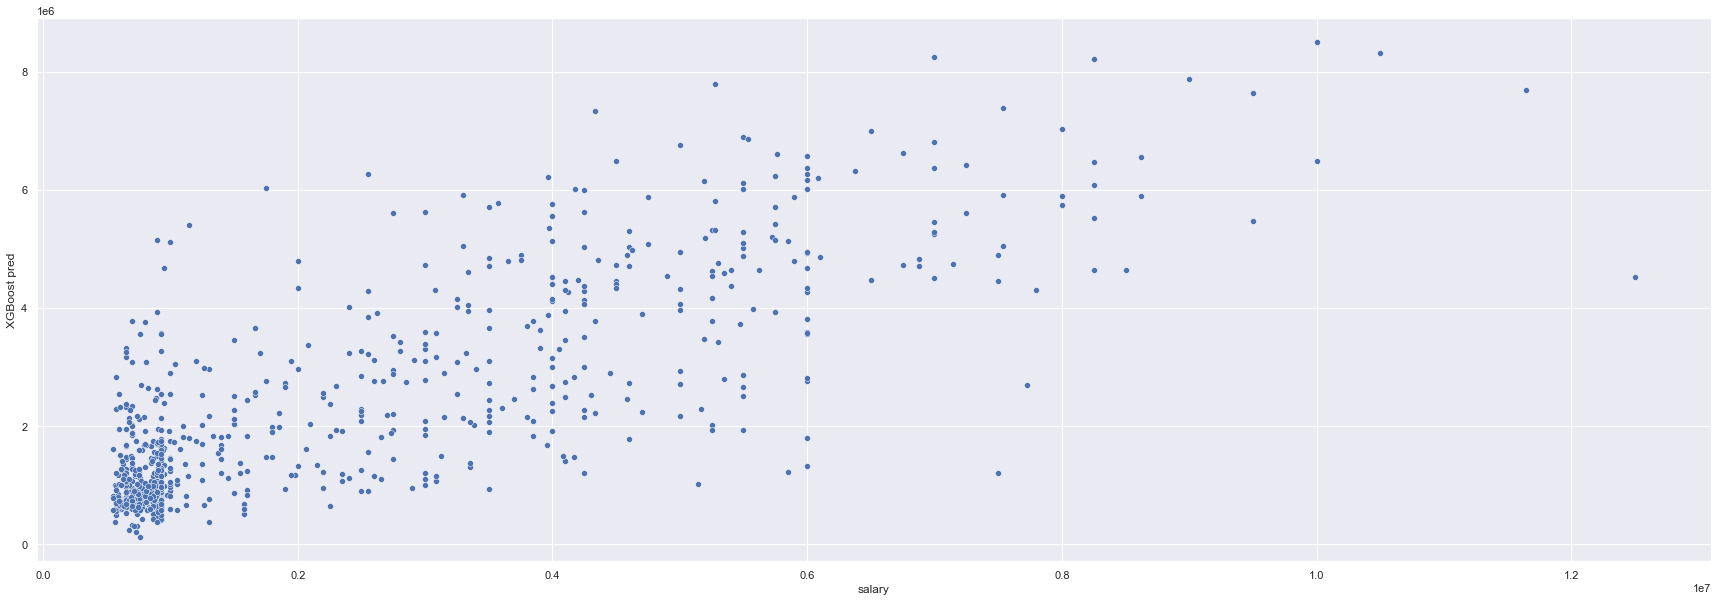

In [154]:
sns.set(rc = {'figure.figsize':(30,10)})
sns.scatterplot(x='salary', y='XGBoost pred', data=results);

In [163]:
clf = XGBRegressor()
selector = RFE(clf, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

In [164]:
for feature in zip(X_train.columns, selector.get_support()):
    if (feature[1] == True):
        print(feature)

('pointsPerGame', True)
('timeOnIce', True)
('faceOffWins', True)
('faceOffLosses', True)
('faceOffPercentage', True)
('blocks', True)
('giveaways', True)
('powerPlayTimeOnIce', True)
('shortHandedTimeOnIce', True)
('age', True)


In [162]:
clf.fit(X_train, y_train)
for feature in zip(X_train.columns, clf.feature_importances_):
    print(feature)

('isC', 0.0014945485)
('isD', 0.010779047)
('isLW', 0.005452178)
('isRW', 0.005696511)
('shootsL', 0.008457275)
('shootsR', 0.0)
('gamesPlayed', 0.014973028)
('goals', 0.008464725)
('assists', 0.0106906425)
('points', 0.011471693)
('pointsPerGame', 0.058527008)
('plusMinus', 0.014001839)
('shots', 0.02814833)
('shootingPercentage', 0.010887391)
('penaltyMinutes', 0.010281521)
('timeOnIce', 0.035684254)
('faceOffWins', 0.022742055)
('faceOffLosses', 0.018727574)
('faceOffTaken', 0.0137217725)
('faceOffPercentage', 0.01270797)
('hits', 0.012558795)
('blocks', 0.028391516)
('takeaways', 0.01795814)
('giveaways', 0.026167814)
('turnoverDifferential', 0.011639815)
('powerPlayGoals', 0.010841217)
('powerPlayAssists', 0.016155016)
('powerPlayPoints', 0.018471254)
('powerPlayTimeOnIce', 0.35221502)
('shortHandedGoals', 0.0048663067)
('shortHandedAssists', 0.00892822)
('shortHandedPoints', 0.009653248)
('shortHandedTimeOnIce', 0.019205565)
('age', 0.16003875)


### Removing Redundant Features
Features in _italics_ are candidates to be dropped
Features in **bold** were in the 10 selected by RFE

Position features:
1. _('isC', 0.0014945485)_
1. ('isD', 0.010779047)
1. ('isLW', 0.005452178)
1. ('isRW', 0.005696511)

<br/>

Handedness features:
1. ('shootsL', 0.008457275)
1. _('shootsR', 0.0)_

<br/>

Scoring features:
1. _('goals', 0.008464725)_
1. ('assists', 0.0106906425)
1. ('points', 0.011471693)
1. **('pointsPerGame', 0.058527008)**

<br/>

Shooting features:
1. ('shots', 0.02814833)
1. ('shootingPercentage', 0.010887391)

<br/>

Powerplay scoring features:
1. _('powerPlayGoals', 0.010841217)_
1. ('powerPlayAssists', 0.016155016)
1. ('powerPlayPoints', 0.018471254)

<br/>

Shorthanded scoring features:
1. _('shortHandedGoals', 0.0048663067)_
1. ('shortHandedAssists', 0.00892822)
1. ('shortHandedPoints', 0.009653248)

<br/>

Faceoff features:
1. **('faceOffWins', 0.022742055)**
1. **('faceOffLosses', 0.018727574)**
1. _('faceOffTaken', 0.0137217725)_
1. **_('faceOffPercentage', 0.01270797)_**

<br/>

Turnover features:
1. ('takeaways', 0.01795814)
1. ('giveaways', 0.026167814)
1. _('turnoverDifferential', 0.011639815)_

<br/>

Non-redundant features:
('plusMinus', 0.014001839)
('penaltyMinutes', 0.010281521)
**('timeOnIce', 0.035684254)**
('hits', 0.012558795)
**('blocks', 0.028391516)**
**('powerPlayTimeOnIce', 0.35221502)**
**('shortHandedTimeOnIce', 0.019205565)**
**('age', 0.16003875)**

Interestingly, there a number of observations that would be contradictory to one's assumptions.
First, goals seem to the feature with the lowest importance score in even strength, powerplay and shorthanded situations. Goals are the only way to score to win games, but according to the importance scores they are not as important as assists or total number of points.

Secondly, faceoffs seem to have a high importance score as faceoff wins, losses and win percentage are in the 10 features selected by RFE, and are three of the features with the highest importance score.

Lastly, time on ice seems to also be an important factor in salary as time on ice in all conditions (even strength, powerplay and shorthanded) are among the top features by importance score and from RFE.